In [153]:
# ---------------------------------------------------------
# 0. Imports
# ---------------------------------------------------------
import pandas as pd

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import MinTrace
from hierarchicalforecast.evaluation import evaluate
from utilsforecast.losses import rmse
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Carregar dados de treino e teste
#    (antes de 2024 = treino, 2024 = teste)
# ---------------------------------------------------------
train_path = "hts1_train_df.csv"  # ajuste para seu caminho real
test_path  = "hts1_test_df.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

# Converte data
for df in (train, test):
    df["date"] = pd.to_datetime(df["date"])

# Se você tiver um único CSV e quiser separar por data, seria algo como:
# data = pd.read_csv("todos_os_dados.csv")
# data["date"] = pd.to_datetime(data["date"])
# train = data[data["date"] < "2024-01-01"].copy()
# test  = data[data["date"] >= "2024-01-01"].copy()

# ---------------------------------------------------------
# 2. Preparar dados no formato esperado pelo HierarchicalForecast
#    - Ignoramos linhas onde continent == 'TOTAL' e deixamos o pacote
#      gerar o TOTAL pela agregação.
#    - Criamos uma coluna de nível superior ("World") constante.
#    - Renomeamos colunas para o padrão: ds (tempo), y (target)
#      e BaseModel (previsão do modelo base).
# ---------------------------------------------------------
def prepare_bottom_level(df: pd.DataFrame) -> pd.DataFrame:
    # Mantém apenas continentes (bottom level)
    df = df[df["continent"] != "TOTAL"].copy()

    df["World"] = "TOTAL"  # nível mais agregado

    df = df.rename(
        columns={
            "date": "ds",
            "continent": "Continent",
            "actual": "y",          # alvo
            "forecast": "BaseModel" # previsões base do seu modelo
        }
    )
    return df[["World", "Continent", "ds", "y", "BaseModel"]]

bottom_train = prepare_bottom_level(train)
bottom_test  = prepare_bottom_level(test)

# ---------------------------------------------------------
# 3. Construir a hierarquia (Total -> Continente) com aggregate
#    spec define os níveis:
#    - ["World"]                        -> série TOTAL
#    - ["World", "Continent"]          -> séries por continente
# ---------------------------------------------------------
hierarchy_levels = [
    ["World"],
    ["World", "Continent"]
]

# Treino: contém y (actual) + BaseModel (previsão 1-step-ahead/insample)
Y_train_df, S_df, tags = aggregate(
    df=bottom_train,
    spec=hierarchy_levels,
    target_cols=["y", "BaseModel"]  # agrega ambos
)

# Teste: contém y (valor observado no teste) + BaseModel (previsão out-of-sample)
Y_test_df, _, _ = aggregate(
    df=bottom_test,
    spec=hierarchy_levels,
    target_cols=["y", "BaseModel"]
)

# ---------------------------------------------------------
# 4. Separar dataframes no formato esperado pela reconciliação
#    - Y_df: dados "históricos" + previsões insample para estimar covariância
#            (aqui estamos usando treino, com colunas y e BaseModel)
#    - Y_hat_df: previsões base no período de teste (futuro)
#            (coluna BaseModel será reconciliada)
# ---------------------------------------------------------
Y_df = Y_train_df.copy()  # contém: unique_id, ds, y, BaseModel

# Y_hat_df: previsões para o horizonte futuro (teste).
# O HierarchicalForecast só precisa das colunas: unique_id, ds e modelos (BaseModel).
Y_hat_df = Y_test_df[["unique_id", "ds", "BaseModel"]].copy()

# ---------------------------------------------------------
# 5. Definir o reconciliador MinT (MinTrace com mint_shrink)
#    Isso é o equivalente ao MinT do FPP3.
# ---------------------------------------------------------
reconcilers = [
    MinTrace(method="mint_shrink"),  # MinT(Shrink),
    MinTrace(method="mint_cov"),
    MinTrace(method="ols")
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

# ---------------------------------------------------------
# 6. Rodar a reconciliação
#    - Y_hat_df: previsões base (teste)
#    - Y_df: dados com y e BaseModel no treino (para estimar matriz de covariância)
#    - S_df, tags: estrutura da hierarquia
# ---------------------------------------------------------
Y_rec_df = hrec.reconcile(
    Y_hat_df=Y_hat_df,
    Y_df=Y_df,
    S=S_df,
    tags=tags,
    intervals_method="bootstrap"
)

# O resultado terá colunas:
#   - "BaseModel" (previsão base incoerente)
#   - "BaseModel/MinTrace_method-mint_shrink" (previsão reconciliada MinT)

print(Y_rec_df.head(10))

# ---------------------------------------------------------
# 7. (Opcional) Juntar com os valores reais de teste e avaliar RMSE
# ---------------------------------------------------------
# Juntando previsões reconciliadas com os valores reais do período de teste
# (Y_test_df tem a coluna "y" com os valores observados nesse período)
Y_eval = Y_rec_df.merge(
    Y_test_df[["unique_id", "ds", "y"]],
    on=["unique_id", "ds"],
    how="left"
)

# Definir tags de avaliação por nível (Total e Continentes)
eval_tags = {
    "Total":     tags["World"],               # nível agregado (WORLD)
    "Continents": tags["World/Continent"],    # nível por continente
}

evaluation = evaluate(
    df=Y_eval,
    metrics=[rmse],
    tags=eval_tags,
    train_df=Y_df,  # opcional, útil p/ métricas tipo MASE
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)

#print(evaluation)


  unique_id         ds      BaseModel  BaseModel/MinTrace_method-mint_shrink  \
0     TOTAL 2024-01-01  141950.822401                          141950.822401   
1     TOTAL 2024-02-01  148428.875032                          148428.875032   
2     TOTAL 2024-03-01  139762.996140                          139762.996140   
3     TOTAL 2024-04-01  100451.947176                          100451.947176   
4     TOTAL 2024-05-01   83612.270975                           83612.270975   
5     TOTAL 2024-06-01   77987.172471                           77987.172471   
6     TOTAL 2024-07-01   90135.436571                           90135.436571   
7     TOTAL 2024-08-01  102421.909781                          102421.909781   
8     TOTAL 2024-09-01   95133.128532                           95133.128532   
9     TOTAL 2024-10-01  118299.327204                          118299.327204   

   BaseModel/MinTrace_method-mint_cov  BaseModel/MinTrace_method-ols  
0                       141950.822401           

### Verificando erros das previsões reconciliadas

In [154]:
new_preds = Y_rec_df.loc[Y_rec_df["unique_id"] == "TOTAL"]
new_preds["model"] = "HTS 1"
new_preds = new_preds.loc[:, ["ds", "BaseModel", "model"]]
new_preds["actual"] = 1
new_preds = new_preds.rename(columns={"ds":"date", "BaseModel":"forecast"})
new_preds


/tmp/ipykernel_77828/2845716393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_preds["model"] = "HTS 1"


,date,forecast,model,actual
0,2024-01-01,141950.822401,HTS 1,1
1,2024-02-01,148428.875032,HTS 1,1
2,2024-03-01,139762.996140,HTS 1,1
3,2024-04-01,100451.947176,HTS 1,1
4,2024-05-01,83612.270975,HTS 1,1
5,2024-06-01,77987.172471,HTS 1,1
6,2024-07-01,90135.436571,HTS 1,1
7,2024-08-01,102421.909781,HTS 1,1
8,2024-09-01,95133.128532,HTS 1,1
9,2024-10-01,118299.327204,HTS 1,1


### Xgboost

In [155]:
xgboost_df = pd.read_csv("xgboost_forecasts.csv")
xgboost_df = xgboost_df[xgboost_df["continent"] == "TOTAL (Agregado)"]
xgboost_df["continent"] = "TOTAL"
xgboost_df["model"] = "xgboost"

In [156]:
xgboost_df

,date,continent,actual,forecast,error,abs_error,pct_error,model
0,2024-01-01,TOTAL,163598.0,141374.900,22223.093750,22223.093750,13.583964,xgboost
1,2024-02-01,TOTAL,170305.0,136395.800,33909.203125,33909.203125,19.910868,xgboost
2,2024-03-01,TOTAL,157683.0,127224.700,30458.296875,30458.296875,19.316158,xgboost
3,2024-04-01,TOTAL,102172.0,87881.400,14290.601562,14290.601562,13.986808,xgboost
4,2024-05-01,TOTAL,84116.0,84481.280,-365.281250,365.281250,-0.434259,xgboost
5,2024-06-01,TOTAL,82402.0,81968.550,433.453125,433.453125,0.526023,xgboost
6,2024-07-01,TOTAL,108089.0,90105.766,17983.234375,17983.234375,16.637432,xgboost
7,2024-08-01,TOTAL,91504.0,106776.360,-15272.359375,15272.359375,-16.690374,xgboost
8,2024-09-01,TOTAL,116003.0,95834.260,20168.742188,20168.742188,17.386397,xgboost
9,2024-10-01,TOTAL,130985.0,124117.010,6867.992188,6867.992188,5.243343,xgboost


### ets

In [157]:
ets_df = pd.read_csv("ets_forecasts_TEST.csv")
ets_df["model"] = "ETS"
ets_df = ets_df[ets_df["continent"] == "TOTAL"]
ets_df = ets_df.rename(columns={"ets_forecast":"forecast"})
ets_df

,date,continent,actual,forecast,error,abs_error,pct_error,ets_model,model_type,arima_model,model
84,2024-01-01,TOTAL,163598.0,133662.015115,29935.984885,29935.984885,18.298503,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)",ETS
85,2024-02-01,TOTAL,170305.0,129759.527000,40545.473000,40545.473000,23.807565,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)",ETS
86,2024-03-01,TOTAL,157683.0,123044.937907,34638.062093,34638.062093,21.966897,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)",ETS
87,2024-04-01,TOTAL,102172.0,90285.614324,11886.385676,11886.385676,11.633702,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)",ETS
88,2024-05-01,TOTAL,84116.0,73504.230933,10611.769067,10611.769067,12.615637,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)",ETS
89,2024-06-01,TOTAL,82402.0,93858.014371,-11456.014371,11456.014371,-13.902593,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)",ETS
90,2024-07-01,TOTAL,108089.0,96835.956171,11253.043829,11253.043829,10.410906,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)",ETS
91,2024-08-01,TOTAL,91504.0,92279.277108,-775.277108,775.277108,-0.847260,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)",ETS
92,2024-09-01,TOTAL,116003.0,78868.542781,37134.457219,37134.457219,32.011635,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)",ETS
93,2024-10-01,TOTAL,130985.0,88924.819494,42060.180506,42060.180506,32.110685,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)",ETS


### sarimax

In [158]:
# TESTE
# Previsoes do sarimax
sarimax_df = pd.read_csv("00_sarimax_forecasts.csv")
sarimax_df = sarimax_df.loc[sarimax_df["continent"] != "Oceania"]

# Previsoes do sarimax oceania
oceania_sarimax_df = pd.read_csv("oceania_sarimax_forecasts.csv")

# Concatenando oceania e geral
sarimax_df = pd.concat([sarimax_df, oceania_sarimax_df])
sarimax_df = sarimax_df[sarimax_df["continent"] == "TOTAL"]
sarimax_df["model"] = "SARIMAX"

In [159]:
sarimax_df

,date,continent,actual,forecast,error,model
0,2024-01-01,TOTAL,163598.0,123556.822653,40041.177347,SARIMAX
1,2024-02-01,TOTAL,170305.0,122984.162911,47320.837089,SARIMAX
2,2024-03-01,TOTAL,157683.0,109541.527253,48141.472747,SARIMAX
3,2024-04-01,TOTAL,102172.0,83833.554549,18338.445451,SARIMAX
4,2024-05-01,TOTAL,84116.0,77021.670173,7094.329827,SARIMAX
5,2024-06-01,TOTAL,82402.0,78387.420604,4014.579396,SARIMAX
6,2024-07-01,TOTAL,108089.0,88322.145471,19766.854529,SARIMAX
7,2024-08-01,TOTAL,91504.0,84738.873935,6765.126065,SARIMAX
8,2024-09-01,TOTAL,116003.0,79048.729137,36954.270863,SARIMAX
9,2024-10-01,TOTAL,130985.0,86033.480733,44951.519267,SARIMAX


In [160]:
actual_df = sarimax_df.loc[:, ["date", "continent", "actual", "model"]]
actual_df["forecast"] = actual_df["actual"]
actual_df["model"] = "actual"
actual_df

,date,continent,actual,model,forecast
0,2024-01-01,TOTAL,163598.0,actual,163598.0
1,2024-02-01,TOTAL,170305.0,actual,170305.0
2,2024-03-01,TOTAL,157683.0,actual,157683.0
3,2024-04-01,TOTAL,102172.0,actual,102172.0
4,2024-05-01,TOTAL,84116.0,actual,84116.0
5,2024-06-01,TOTAL,82402.0,actual,82402.0
6,2024-07-01,TOTAL,108089.0,actual,108089.0
7,2024-08-01,TOTAL,91504.0,actual,91504.0
8,2024-09-01,TOTAL,116003.0,actual,116003.0
9,2024-10-01,TOTAL,130985.0,actual,130985.0


In [161]:
def create_comparison_df(hts_df, sar_df, xgb_df, ets_df, actual_df):
    hts_df, sar_df, xgb_df, ets_df, actual_df = hts_df.copy(), sar_df.copy(), xgb_df.copy(), ets_df.copy(), actual_df.copy()

    cols = ["date", "actual", "forecast", "model"]
    sar_df = sar_df.loc[:, cols]
    xgb_df = xgb_df.loc[:, cols]
    ets_df = ets_df.loc[:, cols]
    actual_df = actual_df.loc[:, cols]

    return pd.concat([hts_df, sar_df, xgb_df, ets_df, actual_df])

In [162]:
comparison_df = create_comparison_df(hts_df = new_preds, sar_df = sarimax_df, xgb_df = xgboost_df, ets_df = ets_df, actual_df=actual_df)

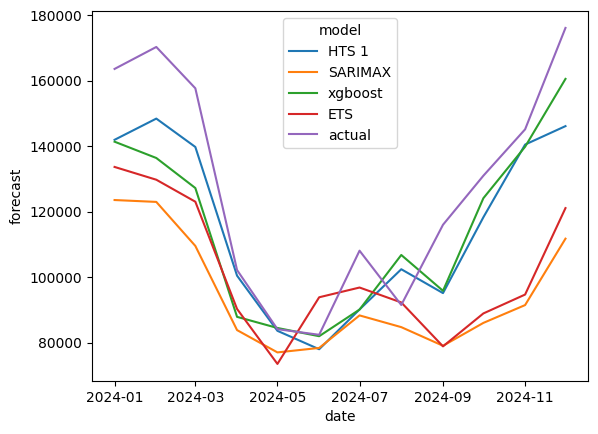

In [163]:
sns.lineplot(data=comparison_df, x="date", y="forecast", hue="model")
plt.show()

In [164]:
Y_rec_df

,unique_id,ds,BaseModel,BaseModel/MinTrace_method-mint_shrink,BaseModel/MinTrace_method-mint_cov,BaseModel/MinTrace_method-ols
0,TOTAL,2024-01-01,141950.822401,141950.822401,141950.822401,141950.822401
1,TOTAL,2024-02-01,148428.875032,148428.875032,148428.875032,148428.875032
2,TOTAL,2024-03-01,139762.996140,139762.996140,139762.996140,139762.996140
3,TOTAL,2024-04-01,100451.947176,100451.947176,100451.947176,100451.947176
4,TOTAL,2024-05-01,83612.270975,83612.270975,83612.270975,83612.270975
...,...,...,...,...,...,...
91,TOTAL/Oceania,2024-08-01,871.676330,871.676330,871.676330,871.676330
92,TOTAL/Oceania,2024-09-01,964.492700,964.492700,964.492700,964.492700
93,TOTAL/Oceania,2024-10-01,1297.831500,1297.831500,1297.831500,1297.831500
94,TOTAL/Oceania,2024-11-01,973.065550,973.065550,973.065550,973.065550
